In [2]:
import os.path as op
import sys
sys.path.append(op.abspath('../'))
sys.path.append(op.abspath('../../../'))

from os import environ
environ["ANAROOT"] = op.abspath('../../../')

# Selection and analysis of peaked background


## Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
from numba import jit

from lib import plot as lp, data, clustering

from project import defs, files, col
from project.defs import dict_color_clu_labels


## Load dataframe

In [5]:
list_voi = [
    'pos_max', #'pos_min',
    'std', 'pedestal',
    'std_pos', 'std_neg',
    'max', 'min', 'mean',
]

columns = [
    'max_m_mean',
    'min_std_pos_neg',
    'min_std_pos_neg_redpn',
    'max_m_mean_red',
    'mean_rounded',
    "max_m_mean_rounded",
    'max_m_min',    
    "std_d_max_m_min",
    "std_without_neg_peaks_d_max_m_min",
    "std_without_pos_peaks_d_max_m_min",
    "relative_mean",
    "std_period_d_mean_period"
]

other_columns = [
    "nb_peaks_sup_80_wrt_min",
    "best_chi2"
]

other_columns += [
    "nb_pos_peaks",
    "nb_neg_peaks"
]

other_columns += [
    "std_without_pos_peaks",
    "std_without_neg_peaks"
]

other_columns += [
    "mean_period_max",
    "mean_period_min",
    "mean_period",
    "std_period_max",
    "std_period_min",
]

other_columns += [
    "mean2_diff_max",
    "mean2_diff_min",
    "mean2_diff"
]


layer = 0

print("Layer", layer, "="*10)
config_name = f"BDT_SNP_layer_{layer}"
file_path = files.get_path_processed_root(config_name)
dataframe, column_labels = files.load_and_process_dataframe(
    file_path, list_voi, columns, other_columns,
    branches=defs.list_samples_columns+["eta", "phi", "region", "detector", "channelId"],
    verbose=True
)

Layer 0 ==========
Time taken to load the ROOT files: 8.516836404800415
ROOT files loaded: /mnt/d/900GeV/processed/simulation/BDT_SNP_layer_0.root
COMPUTE VOIs
Time taken to compute the voi: 43.19726777076721
COMPUTE COLUMNS (not already computed)


In [6]:
dataframe.query("max - min > 3", inplace=True)

## Selection of oscillating background

Oscillating background is known to have:
- To be periodic, hence have a small $\frac{\langle \sigma_{T_e} \rangle}{\langle T_e \rangle}$ (`std_period_d_mean_period`)
- To have quite a large $\frac{\sigma_e}{e_{\text{max}} - e_{\text{min}}}$ because of its large amplitude

Besides, different frequencies have been observed.

#### `std_period_d_mean_period`

# of events: 5089


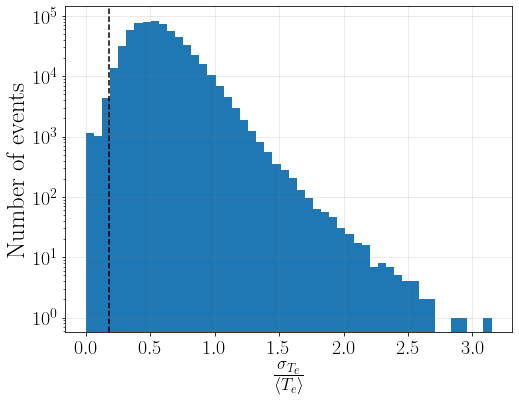

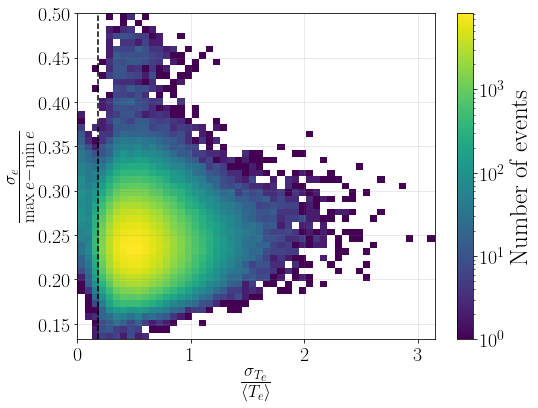

In [67]:
std_period_d_mean_period_high = 0.18
# std_d_max_m_min_low = 0.15

fig, ax = lp.plot_hist(
    dataframe["std_period_d_mean_period"], column_labels["std_period_d_mean_period"],
    logscale=True
)

ax.axvline(
    x=std_period_d_mean_period_high, color='k', linestyle='--'
)

fig2, ax2 = lp.plot_hist2d(
    dataframe["std_period_d_mean_period"],    
    dataframe["std_d_max_m_min"],
    column_labels["std_period_d_mean_period"],
    column_labels["std_d_max_m_min"],
    logscale=True
)

ax2.axvline(
    x=std_period_d_mean_period_high, color='k', linestyle='--'
)
# ax2.axhline(
#     y=std_d_max_m_min_low, color='k', linestyle='--'
# )

periodic_df = dataframe.query(f"std_period_d_mean_period < {std_period_d_mean_period_high}")
very_periodic_df = dataframe.query(f"std_period_d_mean_period == 0")

# periodic_df = dataframe.query(f"std_d_max_m_min > {std_d_max_m_min_low}")
print("# of events:", len(periodic_df))

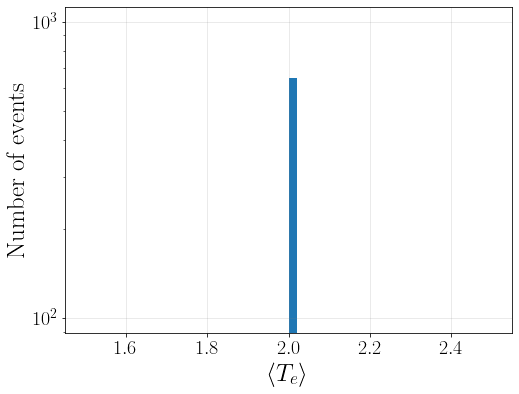

In [83]:
fig, ax = lp.plot_hist(
    very_periodic_df["mean_period"], column_labels["mean_period"],
    logscale=True
)

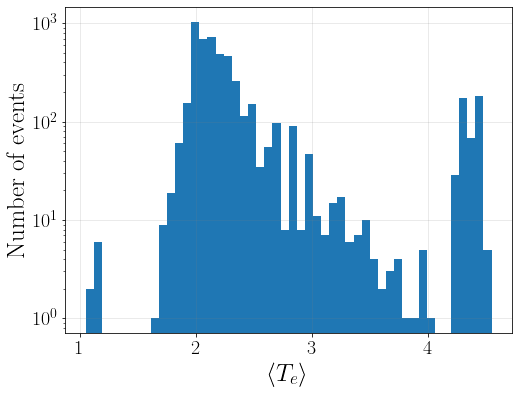

In [82]:
fig, ax = lp.plot_hist(
    periodic_df["mean_period"], column_labels["mean_period"],
    logscale=True
)

### Clustering

In [74]:
clu_label_name = "HDBSCAN"
clu_label_alias = "HDBSCAN"

In [75]:
features = defs.list_samples_columns

In [89]:
from copy import deepcopy
from project import normalize

periodic_df_sample = periodic_df#.sample(50000)
clustering_dataframe = deepcopy(periodic_df_sample)

clustering_dataframe[defs.list_samples_columns] -= np.round(
    data.get_1D_to_2D(clustering_dataframe["mean"])
)
clustering_dataframe[defs.list_samples_columns] /= data.get_1D_to_2D(
    clustering_dataframe["max"] - np.round(clustering_dataframe["mean"])
)

normalize.get_dataframe_pos_max_lined_up(
    clustering_dataframe
)


In [90]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10, min_samples=1, 
    # cluster_selection_epsilon=1.5
)
clusterer.fit(clustering_dataframe[features])


HDBSCAN(min_cluster_size=10, min_samples=1)

In [91]:
periodic_df_sample[clu_label_name] = clusterer.labels_
print(np.unique(periodic_df_sample[clu_label_name]))

[-1  0  1]


/tmp/ipykernel_26464/4078403819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  periodic_df_sample[clu_label_name] = clusterer.labels_


/home/anthony/3A_CS/projet_ATLAS/lib/plot.py:256: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins == "discretised":


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='HDBSCAN', ylabel='Number of events'>)

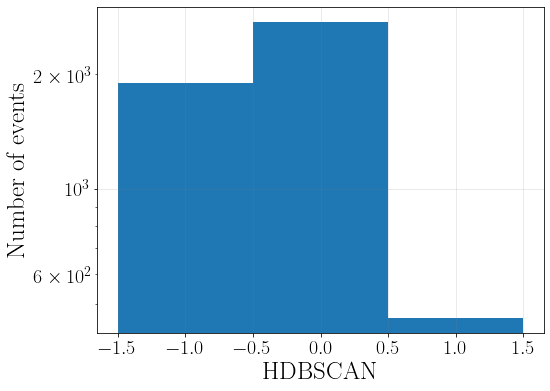

In [92]:
bins = clustering.get_edges_from_clust_labels(
    clusterer.labels_
)

lp.plot_hist(
    periodic_df_sample[clu_label_name],
    clu_label_alias,
    logscale=True,
    bins=bins,
)

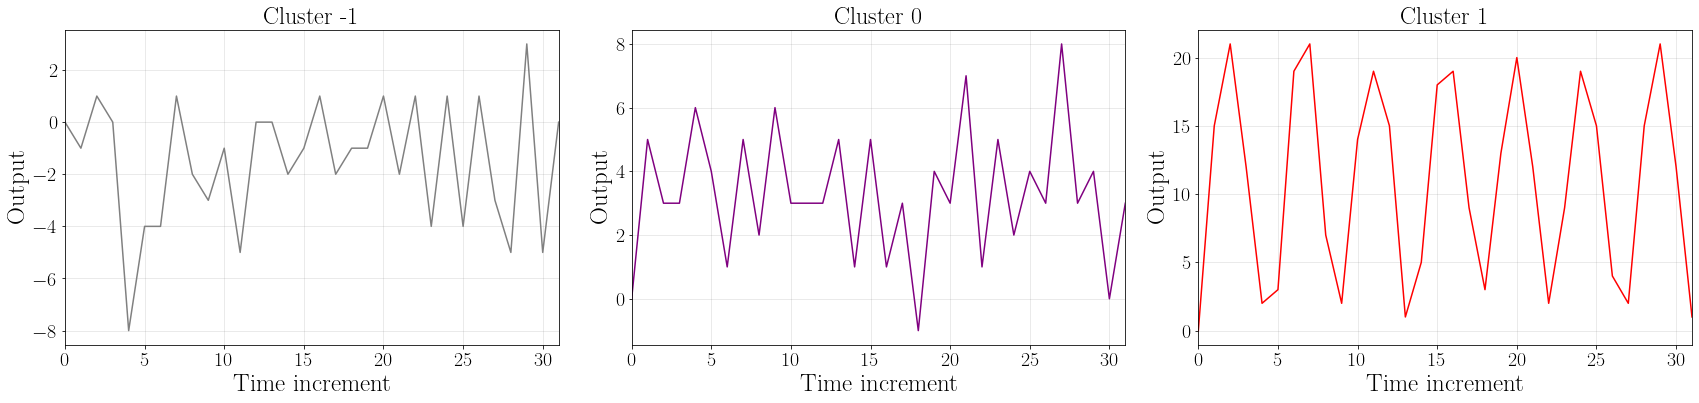

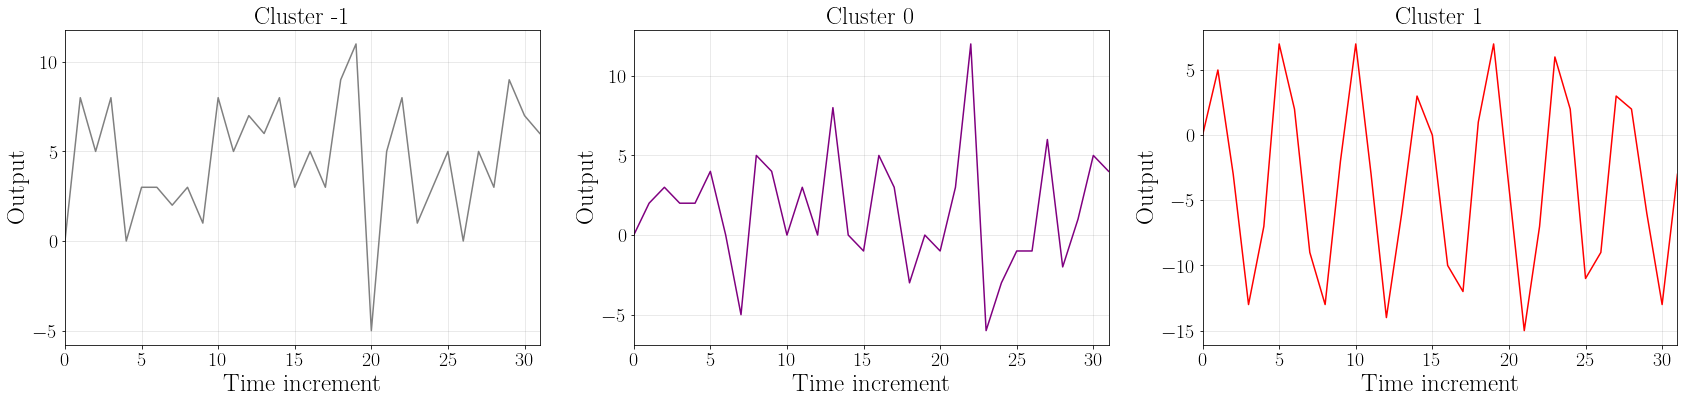

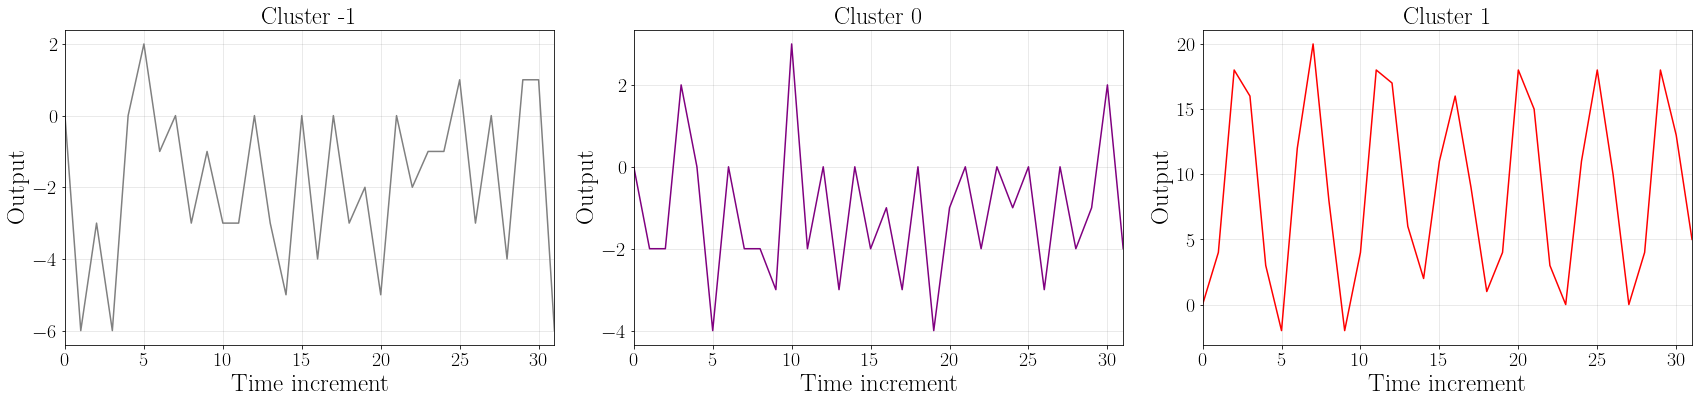

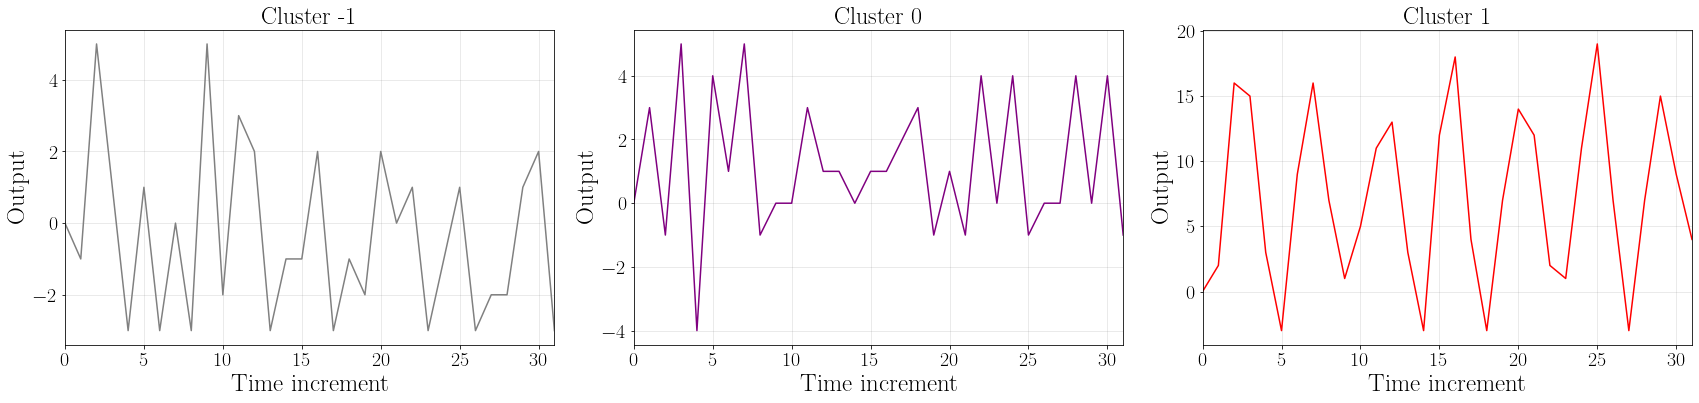

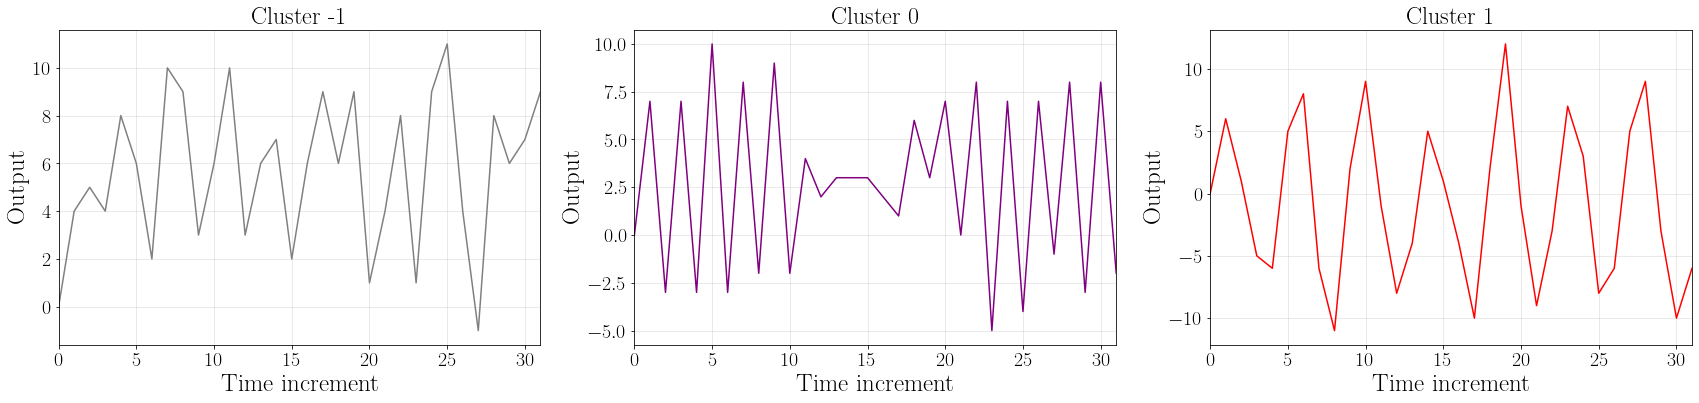

In [93]:
for i in range(5):
    clustering.plot_samples_clusters(
        periodic_df_sample,
        clu_label_name,
        dict_color_clu_labels=dict_color_clu_labels,
    )

{'std_period_d_mean_period_std_d_max_m_min': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x432 with 6 Axes>)}

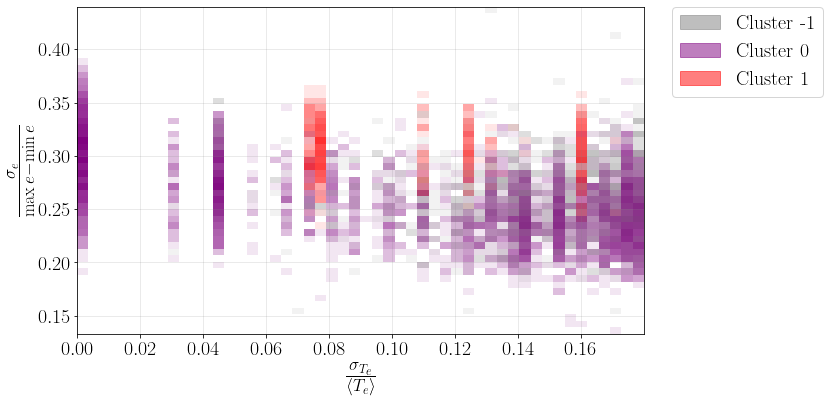

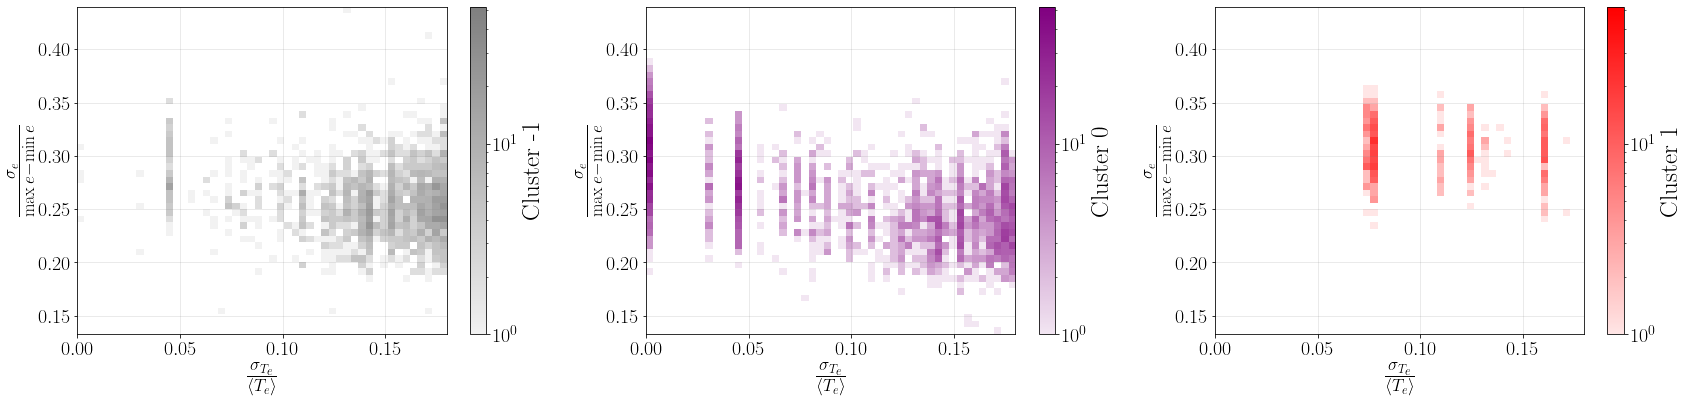

In [95]:
clustering.plot_clusters_hist2d(
    periodic_df_sample, 
    ["std_period_d_mean_period", "std_d_max_m_min"],
    column_labels,
    clu_label_name,
    logscale=True,
    dict_color_clu_cats=dict_color_clu_labels
)

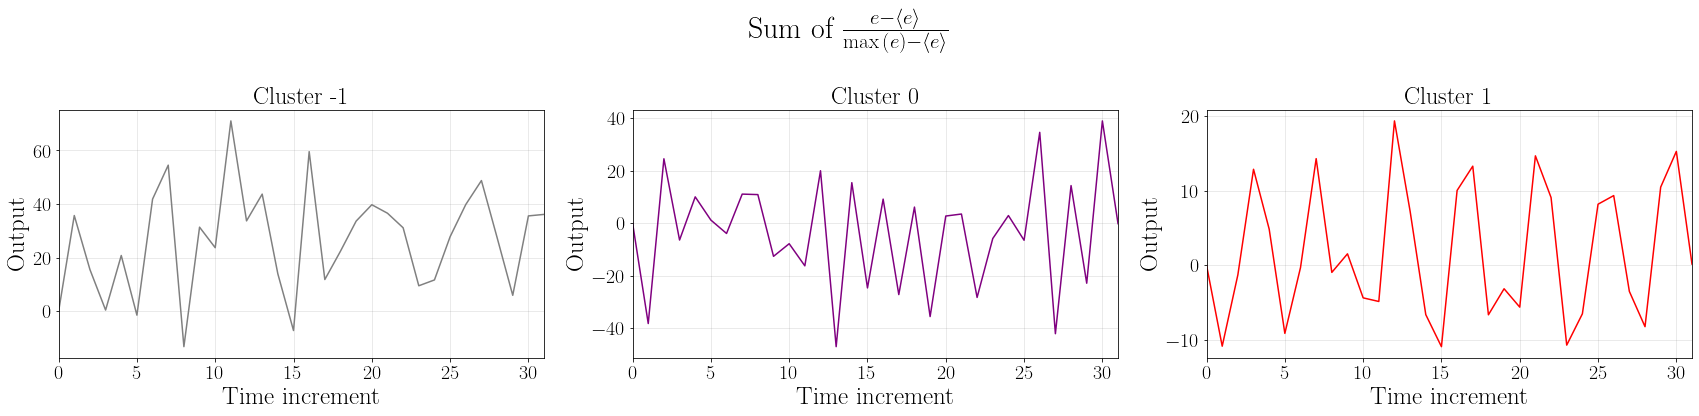

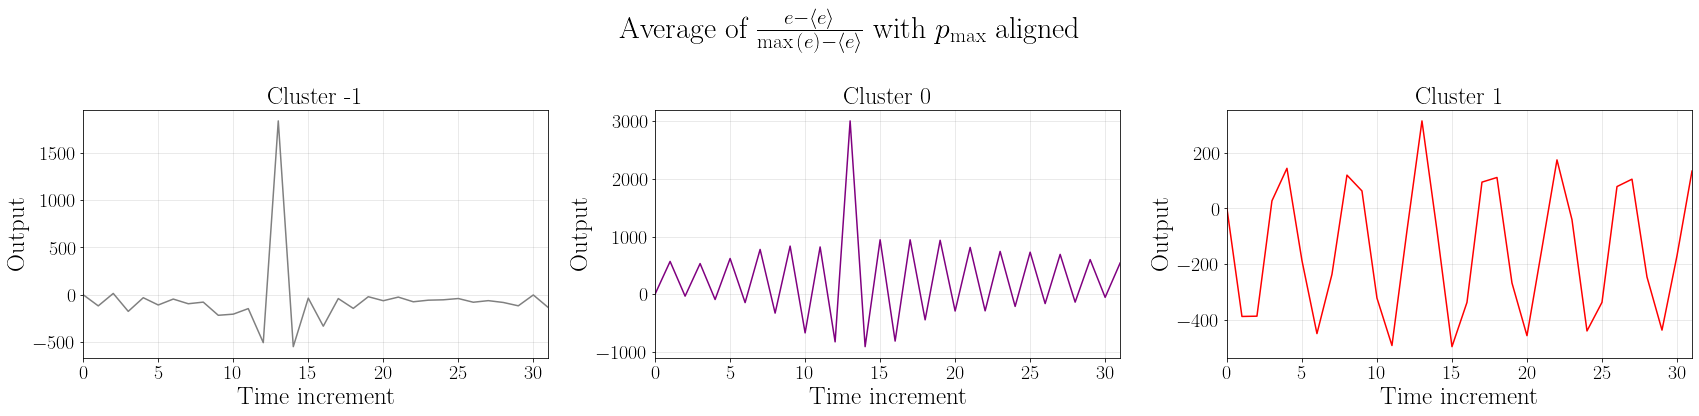

In [96]:
normalised_df = deepcopy(periodic_df_sample)
normalised_df[defs.list_samples_columns] -= data.get_1D_to_2D(normalised_df["mean"])
normalised_df[defs.list_samples_columns] /= data.get_1D_to_2D(normalised_df["max_m_mean"])

fig, _ = clustering.plot_samples_clusters(
    normalised_df,
    clu_label_name,
    dict_color_clu_labels=dict_color_clu_labels,
    method="sum"
)

fig.suptitle(r"Sum of $\frac{e - \langle e\rangle}{\max{\left(e\right)} - \langle e \rangle}$", fontsize=30)
plt.tight_layout()
plt.show(fig)
plt.close(fig)



fig, _ = clustering.plot_samples_clusters(
    normalize.get_dataframe_pos_max_lined_up(
            normalised_df, inplace=False
    ),
    clu_label_name,
    dict_color_clu_labels=dict_color_clu_labels,
    method="sum"
)

fig.suptitle(r"Average of $\frac{e - \langle e\rangle}{\max{\left(e\right)} - \langle e \rangle}$ with $p_{\text{max}}$ aligned", fontsize=30)
plt.tight_layout()
plt.show(fig)
plt.close(fig)

### Analysis

### $(\eta, \phi)$

{'eta_phi': (<Figure size 864x432 with 1 Axes>,
  <Figure size 1728x432 with 6 Axes>)}

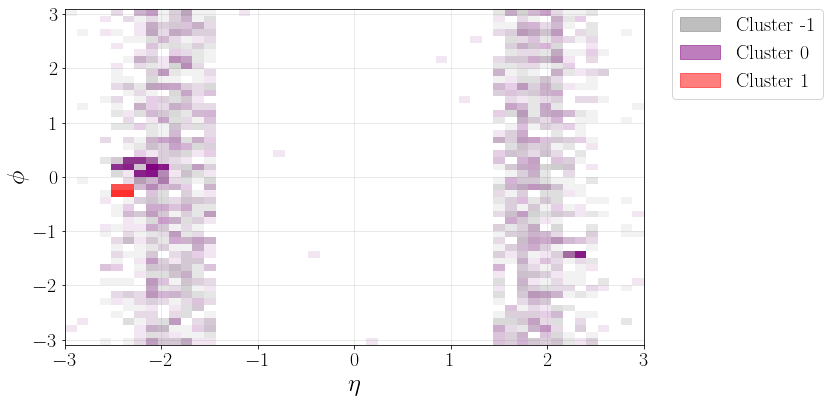

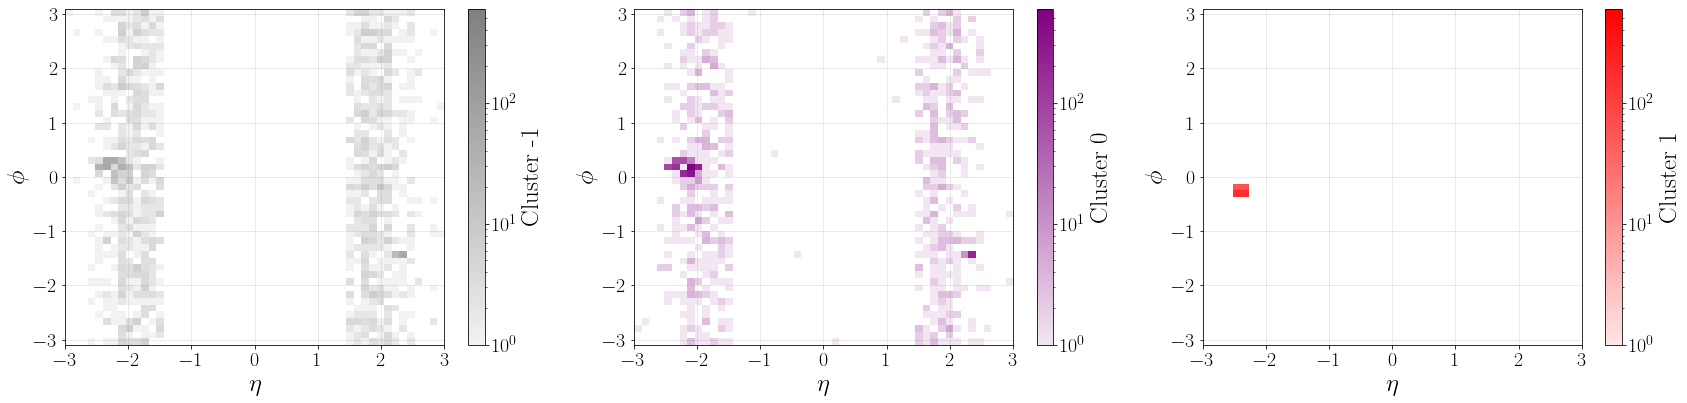

In [122]:
clustering.plot_clusters_hist2d(
    periodic_df_sample, 
    ["eta", "phi"],
    column_labels,
    clu_label_name,
    logscale=True,
    dict_color_clu_cats=dict_color_clu_labels,
)

#### Very periodic

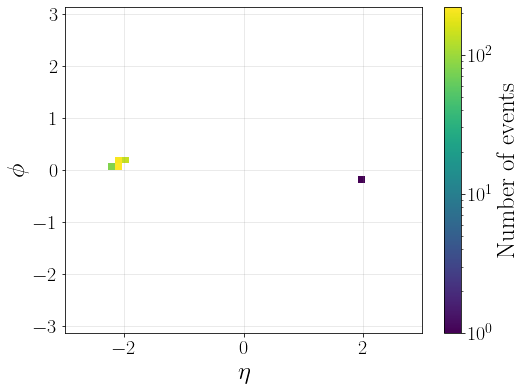

In [120]:
fig2, ax2 = lp.plot_hist2d(
    very_periodic_df["eta"],
    very_periodic_df["phi"],    
    column_labels["eta"],
    column_labels["phi"],
    logscale=True,
    min_max=((-3., 3.), ((-np.pi, np.pi)))
)

648


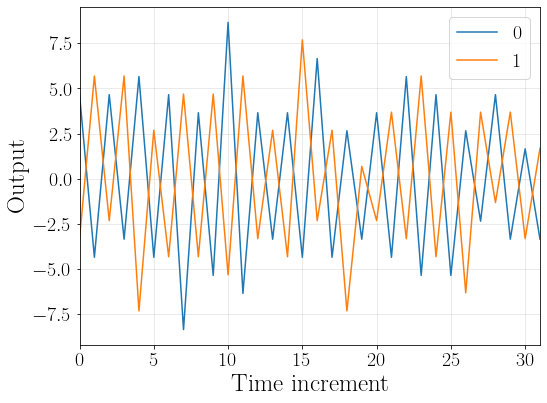

In [102]:
print(len(very_periodic_df))
lp.plot_samples_lots(very_periodic_df.sample(2), minus_mean=True)

In [103]:
very_periodic_df[["channelId", "s0"]].groupby("channelId").count().sort_values("s0", ascending=False)

s0
channelId      
978370560   221
978362880   209
978354688   137
978378752    80
1001430016    1

In [111]:
periodic_df.query(f"{clu_label_name} == 0")[["channelId", "s0"]].groupby("channelId").count().sort_values("s0", ascending=False)

s0
channelId      
978370560   319
978362880   308
978371584   284
978354688   239
1001456128  212
...         ...
981536256     1
981535744     1
981535232     1
981534720     1
1001482240    1

[579 rows x 1 columns]

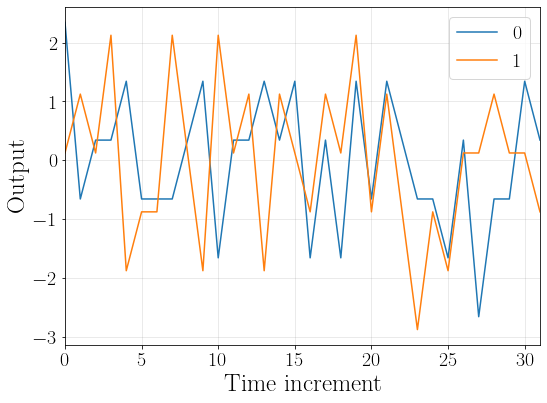

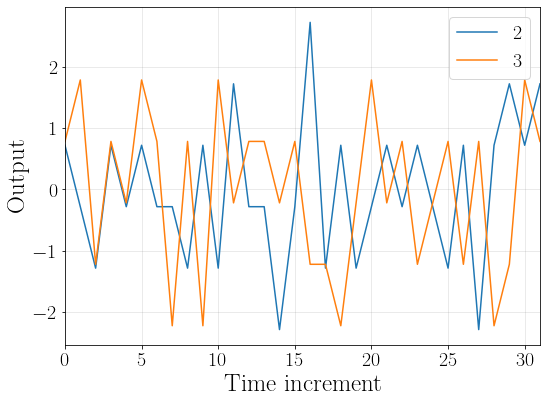

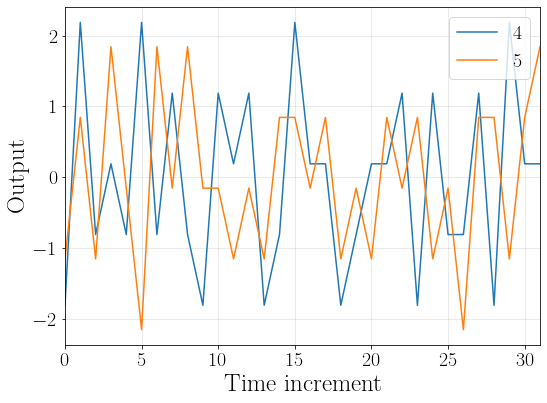

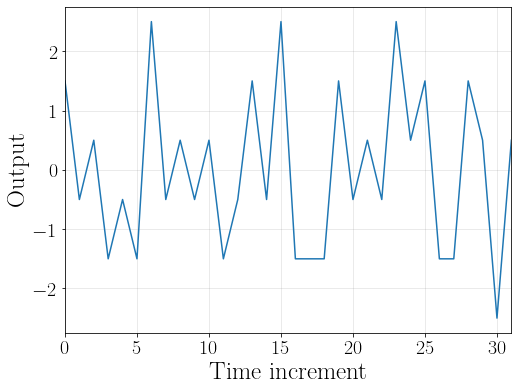

In [115]:
lp.plot_samples_lots(periodic_df.query("channelId==981534720"), minus_mean=True)

### Periodic slow

In [107]:
periodic_df.query(f"{clu_label_name} == 1")[["channelId", "s0"]].groupby("channelId").count().sort_values("s0", ascending=False)

s0
channelId     
981538816  173
981547008  161
981539328   68
981547520   58